# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns

from pandas_profiling import ProfileReport
from pandas.io.json import json_normalize

# Visualización de missing values
import missingno as msno

import klib
%matplotlib inline

#Configuración de  pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Tema JupyterNotebook
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

##### Read dataset

In [34]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [36]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [38]:
# The channels column is regulated by dividing each of the data
portfolio = portfolio.explode('channels')
portfolio.head(5)

,reward,channels,difficulty,duration,offer_type,id
0,10,email,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
0,10,mobile,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
0,10,social,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,web,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
1,10,email,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [119]:
portfolio[portfolio['id'] == 'ae264e3637204a6fb9bb56bc8210ddfd']

,reward,channels,difficulty,duration,offer_type,id
0,10,email,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
0,10,mobile,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
0,10,social,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


In [4]:
# Display dataset profile
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [ ]:
transcript.head(5)

In [109]:
test_df.value.iloc[0:]

0    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
1                       {'amount': 0.5700000000000001}
2     {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
3    {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
4                                     {'amount': 8.22}
5    {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
6     {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
7                                     {'amount': 4.15}
8                                    {'amount': 31.36}
9     {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [128]:
test_df = transcript.sample(50)
test_df.reset_index(drop=True, inplace=True)
test_df

,id,event,value,time
0,a4aa6b434929474089dd981a5020cd5a,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,408
1,c5ae9814adec41ed8e5999362256ba12,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576
2,29238e21ecf4463d82316a6f610915e1,transaction,{'amount': 24.46},444
3,83b26151b9c9487d897a67be32d2eba4,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,408
4,a159f8df69374de387f82fdeae9f27e8,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},6
5,6443155ea95d4ee3afb60fbfbe6d2d73,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},408
6,7248fc98eb6c4b1fb0f1a2cec6ba2f93,transaction,{'amount': 14.93},690
7,742a238ad3ae45ddb0b8c09f13c7fd43,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},504
8,958983269f8544e5ba636832c389faec,transaction,{'amount': 16.63},156
9,6c8127555baa4332a22044807c26aa04,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [217]:
test_function = transcript.head()
test_function

,id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
995,2d5b8dfaa968465b89949bc63fd0cf6b,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
996,f366d7306e6b4aa984e359357cf4e5dc,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
997,4e0f4afd7d524c049f2829c9ad611ab0,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
998,6c0bf1e9a354447689cac11e0e239ea0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [257]:
# Normalize column

def normalize_column(df, column):
    df = df[column].apply(pd.Series)
    df.rename(columns={'offer id': 'offer received'}, inplace=True)
    df.rename(columns={'transaction': 'amount'}, inplace=True)
    df.rename(columns={'offer_id': 'offer completed'}, inplace=True)
    df.rename(columns={'reward': 'offer viewed'}, inplace=True)
    
    return df

def drop_missing_values(df, column):
    normalize_df = normalize_column(df, column)
    
    #print (normalize_df)
    
    offer_id = normalize_df[['offer received']]
    offer_id = offer_id.dropna()
    offer_id = offer_id.reset_index()
    
    amount = normalize_df[['amount']]
    amount = amount.dropna()
    amount = amount.reset_index()
    
    offer_completed = normalize_df[['offer completed']]
    offer_completed = offer_completed.dropna()
    offer_completed = offer_completed.reset_index()
    
    reward = normalize_df[['offer viewed']]
    reward = reward.dropna()
    reward = reward.reset_index()
    
    return offer_id, amount, offer_completed, reward

    #return normalize_df

def merge_dataset(general_dataset, column):
    data_normalize = drop_missing_values(general_dataset, column)
    general_dataset =  general_dataset.reset_index()
    
    final_data = pd.merge(general_dataset, data_normalize[['offer received']].reset_index(), on='index', how="inner")
    final_data = pd.merge(general_dataset, data_normalize[['amount']].reset_index(), on='index', how="inner")
    final_data = pd.merge(general_dataset, data_normalize[['offer completed']].reset_index(), on='index', how="inner")
    final_data =  pd.merge(general_dataset, data_normalize[['offer viewed']].reset_index(), on='index', how="inner")
    
    return final_data

In [258]:
transcript_final = merge_dataset(transcript, "value")
transcript_final.head(20)

TypeError: tuple indices must be integers or slices, not list

In [256]:
transcript_final

,index,id,event,value,time,offer viewed
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN
...,...,...,...,...,...,...
306529,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,NaN
306530,306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,NaN
306531,306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,NaN
306532,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,NaN


In [176]:
test_df['value'].apply(pd.Series)

,offer_id,reward,offer id,amount
0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,NaN
1,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
2,NaN,NaN,NaN,24.46
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,NaN
4,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
5,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
6,NaN,NaN,NaN,14.93
7,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
8,NaN,NaN,NaN,16.63
9,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN


In [74]:
offer_id = test_df['value'].apply(pd.Series)
offer_id = offer_id[['offer id']]
offer_id

,offer id
165942,5a8bc65990b245e5a138643cd4eb9837
204834,3f207df678b143eea3cee63160fa8bed
106292,NaN
171450,NaN
173514,NaN
98140,NaN
215622,NaN
235393,NaN
184551,5a8bc65990b245e5a138643cd4eb9837
242073,NaN


In [142]:
offer_id.reset_index(inplace=True)

In [143]:
amount_id = test_df['value'].apply(pd.Series)
amount_id = amount_id[['amount']]
amount_id.reset_index()

,index,amount
0,0,NaN
1,1,NaN
2,2,24.46
3,3,NaN
4,4,NaN
5,5,NaN
6,6,14.93
7,7,NaN
8,8,16.63
9,9,NaN


In [37]:
# Display dataset transcript
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [63]:
transcript.groupby('event').count()

,id,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


In [42]:
transcript.tail(5)

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


#### EDA (Exploratory Data Analysis)

In [22]:
print(f"Dataset portfolio have {portfolio.shape[0]} rows and {portfolio.shape[1]} columns")
print(f"Dataset portfolio have {profile.shape[0]} rows and {profile.shape[1]} columns")
print(f"Dataset portfolio have {transcript.shape[0]} rows and {transcript.shape[1]} columns")

Dataset portfolio have 33 rows and 6 columns
Dataset portfolio have 17000 rows and 5 columns
Dataset portfolio have 306534 rows and 4 columns


Once the amount of data is taken into account, we will check how many missing values there are in each dataset.

##### Detect missing values for each dataset

<br>

##### Portfolio

In [16]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

As can be seen, this dataset does not have any null value.

##### Profile

In [25]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [33]:
# Ratio of missing values to the actual dataset
print(f"There is a {round(( profile.isnull().sum()[0] / profile.shape[0]) * 100,2)}% of missing values in the dataset Profile ")

There is a 12.79% of missing values in the dataset Profile 


##### Transcript

In [23]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

Like the ``portfolio`` dataset, ``transcript`` has no missing values. 

<br> 

Now we will observe the behavior graphically 

GridSpec(6, 6)

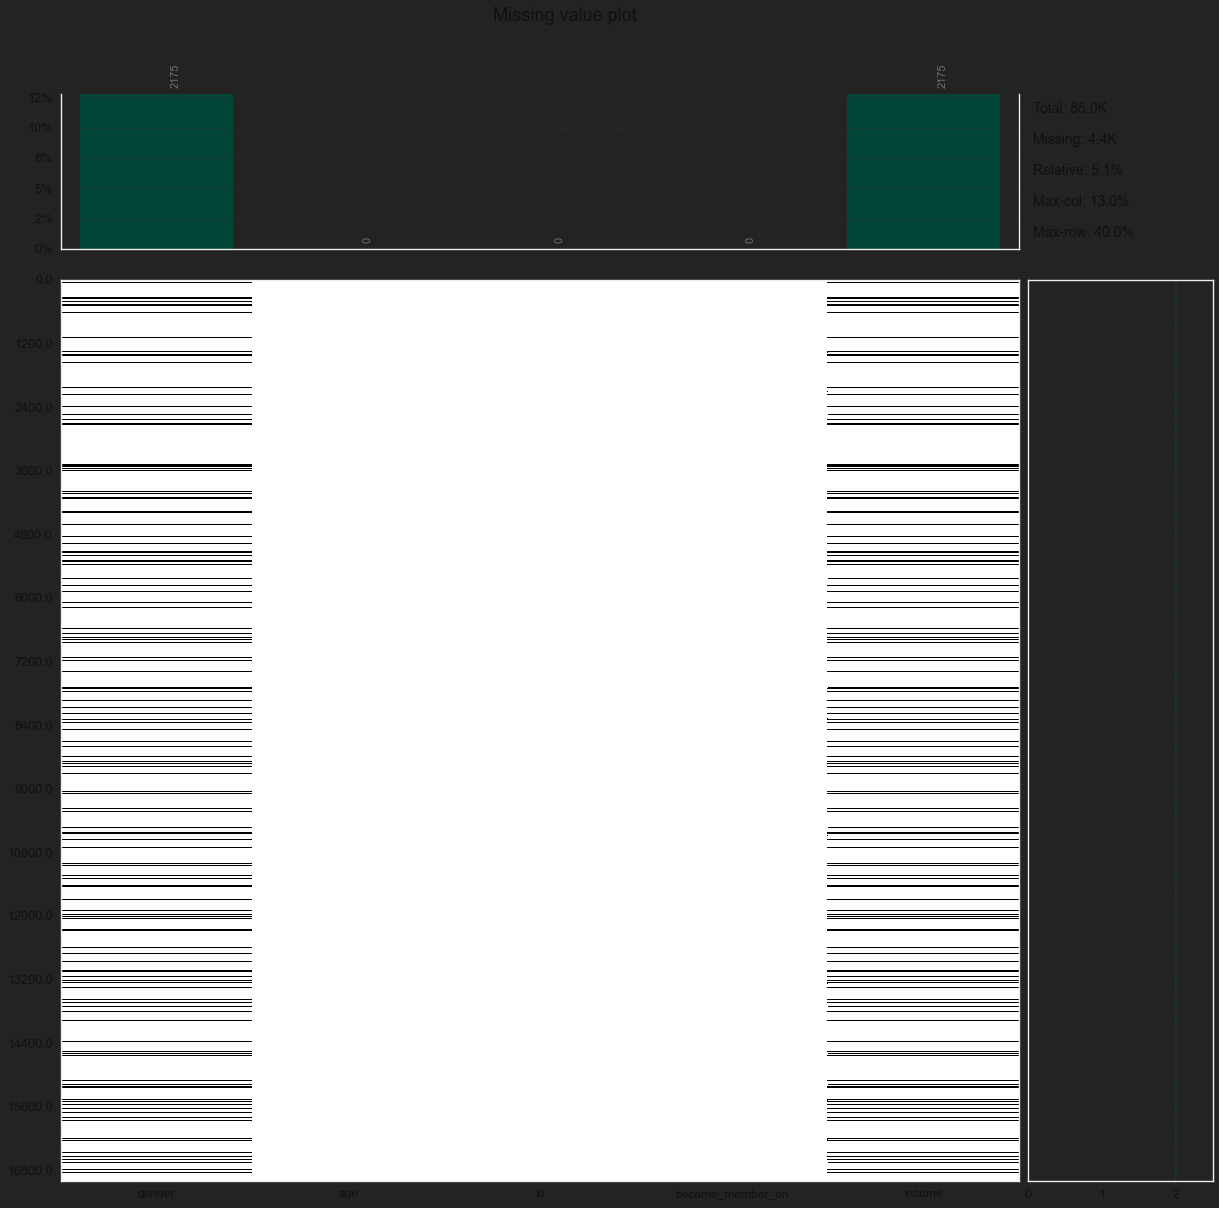

In [13]:
klib.missingval_plot(profile)

A pattern can be observed in the missing values for the gender and income columns. The procedure to be performed is to remove each of these null values. 

In [40]:
transcript.dropna(inplace=True)

In [41]:
# Check again if the dataset transcript contain missing values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

There is a relationship between the three tables that can be related to an ID. However, the name in the ``transcript``dataset must be changed from person to **ID**. As seen below

In [47]:
transcript.rename(columns={'person': 'id'}, inplace=True)

In [49]:
transcript.head(1)

,id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [52]:
test = pd.merge(transcript, profile, on='id')

In [54]:
pd.merge(test, portfolio, on='id')

,id,event,value,time,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type


With the first data cleaning we performed in the previous steps, we will now generate a report to understand the nature of each of the data. 

In [ ]:
# Portfolio report
report = ProfileReport(portfolio, title='Report for dataset Portfolio V1.0', dataset={'creator':'Carlos Barros'},
                        html={'style':{'full_width':True}})

report 
report.to_file("report_portfolio.html")

In [ ]:
# Portfolio report
report = ProfileReport(portfolio, title='Report for dataset Portfolio V1.0', dataset={'creator':'Carlos Barros'},
                        html={'style':{'full_width':True}})

report 
report.to_file("report_portfolio.html")

In [ ]:
# Portfolio report
report = ProfileReport(portfolio, title='Report for dataset Portfolio V1.0', dataset={'creator':'Carlos Barros'},
                        html={'style':{'full_width':True}})

report 
report.to_file("report_portfolio.html")

In [ ]:
klib.corr_plot(df_cleaned, annot=False, figsize=(15,12))
klib.corr_plot(df_cleaned, split='pos', annot=False, figsize=(15,12))
klib.corr_plot(df_cleaned, split='neg', annot=False, figsize=(15,12))

plt.show()

In [ ]:
klib.dist_plot(df_cleaned['win_prob'])
plt.show()

In [ ]:
profile = ProfileReport(portfolio, title='Reporte analisis exploratorio V1.0', dataset={'creator':'Carlos Barros'},
                        html={'style':{'full_width':True}})

profile.to_file("report_v1.html")